<a href="https://colab.research.google.com/github/sumkh/ITI110_AgenticRAG/blob/main/app_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AI Tutor Chatbot (Version 1)

### Setup - Google Colab

In [ ]:
# Download required files from Github repo
!wget https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip /content/Documents.zip


--2025-02-06 15:45:04--  https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip [following]
--2025-02-06 15:45:04--  https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18510909 (18M) [application/zip]
Saving to: ‘Documents.zip’

Documents.zip       100%[===================>]  17.65M  91.7MB/s    in 0.2s    

2025-02-06 15:45:05 (91.7 MB/s) - ‘Documents.zip’ saved [18510909/18510909]

Archive:  /content/Docum

In [ ]:
%%capture
# pip install the required python packages and then manually restart session
!pip install -qU -r requirements.txt


### Install Packages (Restart the Session before Running the Cell Below)

In [ ]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever
from langchain_core.prompts import PromptTemplate

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse

# Local LLM
import multiprocessing
from langchain_community.chat_models import ChatLlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler


# LangGraph React Agent
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenizers parallelism, as it causes issues with multiprocessing


In [ ]:
# (Optional) Setup LangSmith for Observability
# from google.colab import userdata

# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "AgenticRAG"
# os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

### 1. Document Extraction Functions

**References**:
1. RAG with LangChain: https://ds4sd.github.io/docling/examples/rag_langchain/#setup
2. Automatic OCR language detection with tesseract: https://ds4sd.github.io/docling/examples/tesseract_lang_detection/
3. docling-langchain: https://github.com/DS4SD/docling-langchain

In [ ]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents

##### Usage: Loading Documents

Reference: https://ds4sd.github.io/docling/examples/rag_langchain/#document-loading

In [15]:
# # Load general documents from a folder
# gen_doc_path = "./Documents/general"

# docs = load_files_from_folder(gen_doc_path)

# # Display some sample data
# for i, doc in enumerate(docs[:1], start=1):
#     print(f"[Document Chunk #{i}]")
#     print(f"  Source: {doc.metadata.get('source')}")
#     print(f"  Source Type: {doc.metadata.get('source_type')}")
#     print(f"  Doc ID: {doc.metadata.get('doc_id')}")
#     print(f"  Total chars: {len(doc.page_content)}")
#     print(f"  Content (first 100 chars): {doc.page_content[:100]}...\n")

In [16]:
# # Extracting mcq documents from the document folders
# mcq_doc_path = "./Documents/mcq/"

# mcq_docs = load_files_from_folder_mcq(mcq_doc_path)

# # Display some sample data
# for i, doc in enumerate(mcq_docs[:10], start=0):
#     print(f"[Document Chunk #{i}]")
#     print(f"  Source: {doc.metadata.get('source')}")
#     print(f"  Source Type: {doc.metadata.get('source_type')}")
#     print(f"  Doc ID: {doc.metadata.get('doc_id')}")
#     print(f"  Total chars: {len(doc.page_content)}")
#     print(f"  Content (first 100 chars): {doc.page_content[:100]}...\n")


### 2. Website Extraction Functions

In [17]:
# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

##### Usage: Load HTML Documents

In [18]:
# # Usage: Load HTML content from the following web pages
# urls = ["en.wikipedia.org/wiki/Generative_artificial_intelligence",
# "https://python.langchain.com/docs/integrations/vectorstores/chroma/",
# "https://lilianweng.github.io/posts/2023-06-23-agent/"]

# html_docs = extract_html(urls)

# # Display some sample data
# for i, doc in enumerate(html_docs[:1], start=1):
#     print(f"[HTML Document #{i}]")
#     print(f"  Source: {doc.metadata.get('source')}")
#     print(f"  Source Type: {doc.metadata.get('source_type')}")
#     print(f"  Doc ID: {doc.metadata.get('doc_id')}")
#     print(f"  Total chars: {len(doc.page_content)}")
#     print(f"  Content: {doc.page_content}.\n")

### 3. Vector Database

- Reference: https://python.langchain.com/docs/integrations/vectorstores/chroma/
- Reference: https://python.langchain.com/api_reference/chroma/vectorstores/langchain_chroma.vectorstores.Chroma.html
- Reference: https://docs.trychroma.com/reference/python/client
- Reference: https://python.langchain.com/api_reference/chroma/vectorstores/langchain_chroma.vectorstores.Chroma.html#langchain_chroma.vectorstores.Chroma.amax_marginal_relevance_search

In [19]:
embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


In [21]:
# # Add the chunked texts to the Chroma instance
# chunked_docs = split_text_into_chunks(docs + html_docs)

# #general_vs.add_documents(chunked_docs) # Note: uncomment if want to add to general_vs vector store

# logger.info(f"Added {len(chunked_docs)} documents to the General vector store.")

# # Retrieve a samples (Lower score represents more similarity) from the vector store
# results = general_vs.similarity_search_with_score("What is Artificial Intelligence", k=1)
# for res, score in results:
#     print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


In [22]:
# # Add documents to the MCQ vector store (Note: Do not chunk the mcq documents)
# #mcq_vs.add_documents(mcq_docs) # Note: uncomment if want to add to mcq_vs vector store

# logger.info(f"Added {len(mcq_docs)} documents to the MCQ vector store.")

# # Retrieve a samples (Lower score represents more similarity) from the vector store
# results_mcq = mcq_vs.similarity_search_with_score("What is Artificial Intelligence", k=5)
# for res, score in results_mcq:
#     print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


In [ ]:
# Usage: Load HTML content from the following web pages
urls = "https://www.ibm.com/think/topics/artificial-intelligence"
temp_docs = extract_html(urls)


# Add documents to the in-memory vector store
chunked_docs_in_memory = split_text_into_chunks(temp_docs) # Placeholder, replace with in-memory documents
in_memory_vs.add_documents(chunked_docs_in_memory)

# # Retrieve a samples (Lower score represents more similarity) from the vector store
# results_in_memory = in_memory_vs.similarity_search_with_score("What is Artificial Intelligence", k=1)
# for res, score in results_in_memory:
#     print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


### 4. Retrievers and Tool Configurations

- Reference: https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStoreRetriever.html#langchain_core.vectorstores.base.VectorStoreRetriever.search_kwargs
- Reference: https://api.python.langchain.com/en/latest/tools/langchain.tools.retriever.create_retriever_tool.html#:~:text=create_retriever_tool-,langchain.tools.retriever.,document_separator%20(str)%20–
- Reference: https://python.langchain.com/docs/concepts/tools/
- Reference: https://python.langchain.com/docs/how_to/tools_builtin/
- Reference: https://python.langchain.com/docs/how_to/custom_tools/

In [24]:
# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 10) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Retriever from database for Multiple Choice Questions (MCQ) for the quiz generation.

    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A dictionary of MCQ questions with the following key value pairs:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content
    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# Example usage
#input = "Generate a quiz to test about Artificial Intelligence"
#mcq_retriever(input, k=5)



In [25]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "General Retrieval Tool",
    description = (
    """
    Retriever from database for general queries and study guide generation.
    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# Example usage
#input = "What is Artificial Intelligence"
#gen_retriever(input, k=5)


In [26]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(1, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Retriever from user uploaded documents.
    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# Example usage
#input = "What is Artificial Intelligence"
#in_memory_retriever(input, k=1)


In [27]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query about web content extracted into in-memory vector store only
# Useful if the dataset has many similar documents

# web_retrieval = in_memory_vs.as_retriever(
#     search_type="mmr",
#     search_kwargs={
#         'k': 10,
#         'lambda_mult': 0.25,
#         'filter':{"source_type": "web"}
#     },
# )

# # Example usage
# input = "What is Artificial Intelligence"
# web_retrieval.invoke(input, k=5)


In [28]:
# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    url: str = Field(
        ...,
        title="url",
        description="urls to extract content from"
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from a web URL, load into in_memory_vstore.

    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.

    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # extracted_html = {}

    # # Convert LangChain Document format into a JSON response
    # for i, doc in enumerate(html_docs):
    #     extracted_html[f"id{i}"] = {
    #         "source": doc.metadata.get("source"),
    #         "content": doc.page_content
    #     }

    #print(f"Extracted {len(html_docs)} documents successfully.")
    #return extracted_html

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        "Assistant should use this tool to extract content from web URLs based on user's input, "
        "Web extraction is initially load into database and then return k: Number of results to retrieve"
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# Example usage
#input = "What is Artificial Intelligence"
#url1 = "https://learn.microsoft.com/en-gb/training/modules/prepare-to-develop-ai-solutions-azure/2-define-artificial-intelligence"
#url2 = "https://www.ibm.com/think/topics/artificial-intelligence"
#extract_web_path_tool(input, url1, k=5)

In [29]:
# Ensemble Retrieval from General and In-Memory Vector Stores
# Reference: https://python.langchain.com/api_reference/langchain/retrievers/langchain.retrievers.ensemble.EnsembleRetriever.html#langchain.retrievers.ensemble.EnsembleRetriever.invoke
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def ensemble_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Retriever from database for general queries and study guide generation.
    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )

# Example usage
#input = "What is Artificial Intelligence"
#ensemble_retriever(input, k=10)


### 5. Local CPU-based LLM

- Reference: https://python.langchain.com/docs/integrations/llms/llamacpp/
- Reference: https://python.langchain.com/api_reference/community/chat_models/langchain_community.chat_models.llamacpp.ChatLlamaCpp.html#chatllamacpp
Reference: https://medium.com/@nkrasnytskyi/running-quantized-llama-models-locally-on-macos-with-langchain-and-llama-cpp-a-step-by-step-guide-124d33592c09

In [30]:
# from llama_cpp import Llama

# #Source: https://huggingface.co/hugging-quants/Llama-3.2-3B-Instruct-Q4_K_M-GGUF

# local_llm = Llama.from_pretrained(
# 	repo_id="hugging-quants/Llama-3.2-3B-Instruct-Q4_K_M-GGUF",
# 	filename="llama-3.2-3b-instruct-q4_k_m.gguf",
# )


In [31]:
# CMAKE_ARGS="-DLLAMA_METAL=on" # for Metal GPU acceleration"
# #CMAKE_ARGS="-DLLAMA_CUBLAS=on" # for CUDA GPU acceleration"
# FORCE_CMAKE="1"


# # If load for the model binary in your local drive
# MODEL_PATH = "models/llama-3.2-3b-instruct-q4_k_s.gguf"

# # Based on the above model loaded from Huggingface, locate the model binary in Google Colab
# #LLAMA_CURL="1 make"
# #MODEL_PATH = "/root/.cache/huggingface/hub/models--hugging-quants--Llama-3.2-3B-Instruct-Q4_K_M-GGUF/snapshots/eb72f2a08dd2b9edd07ffacfe5aa56938b7939b0/llama-3.2-3b-instruct-q4_k_m.gguf"

# # Initialize the LlamaCpp model
# localllm = ChatLlamaCpp(
#     model_path=MODEL_PATH,
#     n_gpu_layers=1,     # set to 0 for CPU, or -1 to offload all layers to GPU (Metal set to 1 is enough)
#     n_batch=512,        # default=8, tweak for speed/memory, adjusted for Mac's resources
#     n_ctx=2048,         # context window in tokens
#     f16_kv=True,        # half-precision key/values
#     temperature=0.5,    # default=0.8 (adjust as needed)
#     callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
#     verbose=True,  # Verbose is required to pass to the callback manager
# )

# print(localllm.invoke("Hello, I am your AI Tutor for Deep Learning. How can I help you today?"))

In [61]:
from langchain_groq import ChatGroq
GROQ_API_KEY = userdata.get("GROQ_API_KEY")

#from google.colab import userdata
#GROQ_API_KEY = userdata.get('GROQ_API_KEY')

# Initialize Groq LLM
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0.6,
    api_key=GROQ_API_KEY,
    verbose=True
)

### 6. Creating the LangGraph React Agent

### Best LangGraph to Use: AgentExecutor with Train of Thoughts

### LangGraph with Memory

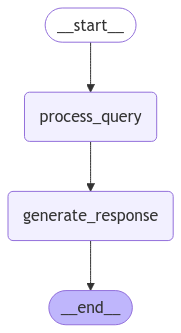

In [56]:
from typing import List
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain.agents import initialize_agent, AgentType
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph

# ------------------------------------------------------------------
# process_query Node
# ------------------------------------------------------------------
def process_query(input_dict: dict, config: dict = None) -> dict:
    state: MessagesState = input_dict.get("state", MessagesState())

    messages = input_dict.get("messages", [])
    state["messages"] = messages

    query = messages[-1].content if messages and isinstance(messages[-1], HumanMessage) else "No query provided."

    # Initialize the agent
    agent = initialize_agent(
        tools=tools,
        llm=llm, # your local llama-cpp LLM
        agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )

    agent_states = agent.run({"input": query})
    updated_messages = messages + [AIMessage(content=agent_states)]
    state["messages"] = updated_messages
    return {"messages": updated_messages, "state": state}

# ------------------------------------------------------------------
# Generate Response (Uses any retrieved context to form an answer)
# ------------------------------------------------------------------
def generate_response(state: MessagesState):
    """Generates the final response while maintaining context."""
    messages = state.get("messages", [])

    # Construct a system message that includes the retrieved content
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the tools to retrieve information and generate responses based on "
        "the user's query. If you don't know the answer, state that clearly "
        "and ask the user to clarify or rephrase their question. "
        "If possible, attempt to address the question based on your internal knowledge.\n\n"
    )

    system_message_content_mcq = (
        "You are a Multiple-Choice Quiz Trainer. "
        "Use the tools to generate MCQ questions based on the provided context.\n\n"
    )

    # Combine system message with conversation context
    conversation_messages = [
        f"User: {message.content}" if isinstance(message, HumanMessage) else f"AI: {message.content}"
        for message in messages
    ]
    QnA_prompt = system_message_content + "\n\n" + "\n".join(conversation_messages)
    MCQ_prompt = system_message_content_mcq + "\n\n" + "\n".join(conversation_messages)

    # Decide which prompt to use based on the latest message
    last_message = messages[-1].content.lower() if messages else ""
    prompt_to_use = MCQ_prompt if "quiz" in last_message or "multiple choice" in last_message else QnA_prompt

    try:
        final_response = llm(prompt_to_use)
    except Exception as e:
        final_response = f"Error generating response: {str(e)}"

    return {"messages": messages + [AIMessage(content=final_response)]}

# ------------------------------------------------------------------
# Build & Compile the Graph
# ------------------------------------------------------------------
graph_builder = StateGraph(MessagesState)

# Ensure 'process_query' is properly defined elsewhere
graph_builder.add_node("process_query", process_query)
graph_builder.add_node("generate_response", generate_response)  # Add the generate_response node

graph_builder.set_entry_point("process_query")
graph_builder.add_edge("process_query", "generate_response")
graph_builder.add_edge("generate_response", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

#### Request to Generate MCQ Quizzes

In [57]:
# ------------------------------------------------------------------
# Example Usage
# ------------------------------------------------------------------
messages = [
    HumanMessage(content="Provide 5 MCQ questions on Artificial Intelligence to help me with practice. Please do not give me the answer right away. Wait for me to answer first and then provide the answer with explanations."),
]

# Checkpoint config (optional)
config = {
    "configurable": {
        "thread_id": "example_thread",
        "checkpoint_ns": "example_namespace",
        "checkpoint_id": "query_1",
    }
}

# Invoke the graph with configuration
result = graph.invoke({"messages": messages}, config=config)




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "MCQ Retrieval Tool",
  "action_input": {"input": "Artificial Intelligence", "k": 5}
}
```

Observation: {'./Documents/mcq/mcq.csv_Qn2 mcq_question': 'Your organization is developing a decision support solution to monitor data for anomalies and deliver real-time insights to stakeholders. The solution requires continuous monitoring and automated alerts for deviations from expected patterns. Which Azure AI service should you select to implement the data monitoring aspect effectively?', './Documents/mcq/mcq.csv_Qn2 mcq_answer': 'Answer - [A] Azure AI Metrics Advisor', './Documents/mcq/mcq.csv_Qn2 mcq_answer_reason': 'Option A - Azure AI Metrics Advisor: Specifically designed for real-time anomaly detection and continuous data monitoring, making it the best fit for the given scenario.|EXAM FOCUS - Always remember to use Azure AI Metrics Advisor for real-time data monitoring and anomaly detection. Make sure the solution is se

In [58]:
messages = [
    HumanMessage(content="For the earlier provided MCQ Questions, my answers are as follows: Qn1: A, Qn2: B, Qn3: C, Qn4: D, Qn5: A. Please provide the answers with explanations in bullet points."),
]

# Invoke the graph with configuration
result = graph.invoke({"messages": messages}, config=config)




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "MCQ Retrieval Tool",
  "action_input": {"input": "Earlier provided MCQ Questions", "k": 5}
}
```

Observation: {'./Documents/mcq/mcq.csv_Qn34 mcq_question': 'What efficient methods can Azure AI engineers employ for importing content sources in a question answering solution? Select all answers that apply.', './Documents/mcq/mcq.csv_Qn34 mcq_answer': 'Answer - [B, C]', './Documents/mcq/mcq.csv_Qn34 mcq_answer_reason': 'Option B - Utilizing Azure Blob Storage allows large-scale data import efficiently.|Option C - Integrating with Azure SQL Database enables structured data integration for easy querying.|EXAM FOCUS - You should use Azure Blob Storage for large-scale data imports and SQL Database for structured data. Keep in mind that these methods are scalable and efficient for content source imports.|CAUTION ALERT - Avoid relying on manual uploads, which are inefficient for large-scale projects. Stay clear of ignoring conte

In [59]:
messages = [
    HumanMessage(content="for each of the answered MCQ questions, provide the solution in details."),
]

# Invoke the graph with configuration
result = graph.invoke({"messages": messages}, config=config)




> Entering new AgentExecutor chain...
To provide detailed solutions for each of the answered MCQ questions, I first need to retrieve the questions. 

Action:
```
{
  "action": "MCQ Retrieval Tool",
  "action_input": {"input": "AI", "k": 5}
}
```

Observation: {'./Documents/mcq/mcq.csv_Qn20 mcq_question': 'Your company is developing an AI-powered traffic management system for a smart city project. The system needs to analyze video feeds from surveillance cameras installed at various intersections to monitor vehicle flow and detect traffic congestion in real-time. You are tasked with selecting the appropriate Azure AI service to implement spatial analysis for people movement to optimize traffic flow. Which Azure AI service should you recommend based on the requirements and the need for accuracy and real-time processing?', './Documents/mcq/mcq.csv_Qn20 mcq_answer': 'Answer - [D] Azure AI Vision Spatial Analysis.', './Documents/mcq/mcq.csv_Qn20 mcq_answer_reason': 'EXAM FOCUS - Always re

#### Request for Study Guide Generation

In [62]:
messages = [
    HumanMessage(content="Please prepare a set of suitable learning outcome to study Deep Learning from database."),
]

# Invoke the graph with configuration
result = graph.invoke({"messages": messages}, config=config)




> Entering new AgentExecutor chain...
<think>
Okay, the user wants me to prepare a set of suitable learning outcomes for studying Deep Learning. I remember that the Ensemble Retriever Tool can help fetch relevant content from the database. Let me use that tool with the input "Deep Learning learning outcomes" and set k to 10 to get enough results. I'll structure the JSON blob accordingly to retrieve the necessary information.
</think>

Action:
```json
{
  "action": "Ensemble Retriever Tool",
  "action_input": {
    "input": "Deep Learning learning outcomes",
    "k": 10
  }
}
```


Observation: ['How Do Children Learn?\nThe Deep Learning Revolution', 'between inputs and outputs in the training data, so it can predict the labels of new, unseen data.     Deep learning   Deep learning is a subset of machine learning that uses multilayered neural networks, called deep neural networks, that more closely simulate the complex decision-making power of the human brain. Deep neural networks inc

#### General Questions with Web Searches

In [51]:
# URL
url1 = "https://www.ibm.com/think/topics/artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/machine-learning"


messages = [
    HumanMessage(content="Find out about Deep Learning from databases. Then search from website to answer different between machine learning vs artificial intelligence? Website:" + url1 + " and Website:" + url2),
]

# Invoke the graph with configuration
result = graph.invoke({"messages": messages}, config=config)




> Entering new AgentExecutor chain...
<think>
Okay, I need to figure out how to help the user understand the difference between Machine Learning and Artificial Intelligence. The user has provided specific websites from IBM, so I should start by extracting information from those. 

First, I'll use the Web Extraction Tool to get content from both URLs. That way, I can gather IBM's definitions and explanations on both topics. I'll set k=5 to retrieve enough relevant information.

Once I have the extracted content, I'll look for key points that differentiate AI and ML. Typically, AI is the broader field, while ML is a subset focused on algorithms learning from data. I should highlight that AI includes more than just ML, like rule-based systems.

I also want to make sure the information is accurate and up-to-date, so relying on IBM's resources should be reliable. After extracting, I'll organize the information into a clear, concise explanation for the user.
</think>

Action:
```json
{
  "